In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

In [ ]:
labels = ['normal', 'pneumonia']
img_size = 224
def get_data(data_dir):
  imgs = []
  label_list = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img))
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        imgs.append(resized_arr)
        label_list.append(class_num)
      except Exception as e:
        print(e)
  return np.array(imgs), np.array(label_list)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
general_path = '/content/drive/MyDrive/datasets/chest_x-ray'
X_train, y_train = get_data(os.path.join(general_path, 'train'))
X_test, y_test = get_data(os.path.join(general_path, 'test'))
X_val, y_val = get_data(os.path.join(general_path, 'val'))

<Axes: ylabel='count'>

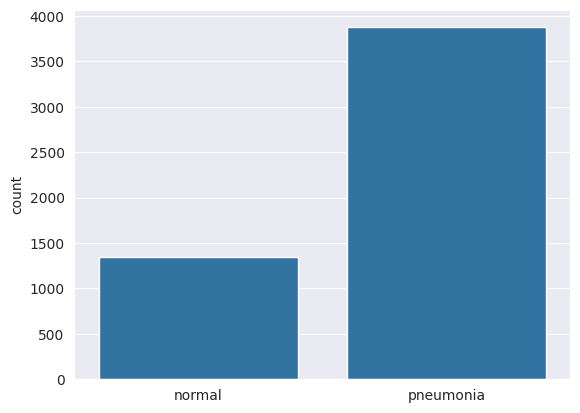

In [ ]:
input_list = []
for i in y_train:
  if i == 0:
    input_list.append('normal')
  else:
    input_list.append('pneumonia')
sns.set_style('darkgrid')
sns.countplot(x=input_list)

Text(0.5, 1.0, 'pneumonia')

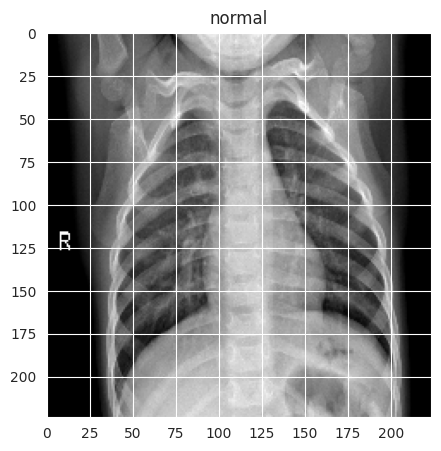

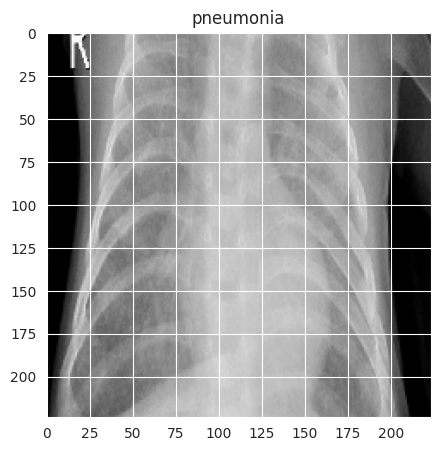

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0], cmap='gray')
plt.title(labels[y_train[0]])

plt.figure(figsize=(5, 5))
plt.imshow(X_train[-1])
plt.title(labels[y_train[-1]])

In [ ]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
X_val = preprocess_input(X_val)

In [ ]:
augm = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [ ]:
base_model = ResNet50(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

inputs = Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
call_backs = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('model.h5', save_best_only=True, verbose=1, monitor='val_accuracy', mode='max')
]

In [ ]:
trained = model.fit(
    augm.flow(X_train, y_train, batch_size = 32),
    epochs = 25,
    validation_data = augm.flow(X_val, y_val),
    callbacks = call_backs,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8390 - loss: 0.4443
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 861s 5s/step - accuracy: 0.8393 - loss: 0.4434 - val_accuracy: 0.9375 - val_loss: 0.2677 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9169 - loss: 0.2088
Epoch 2: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 837s 5s/step - accuracy: 0.9170 - loss: 0.2088 - val_accuracy: 0.6875 - val_loss: 0.7484 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9316 - loss: 0.1762
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.9316 - loss: 0.1762 - val_accuracy: 0.7500 - val_loss: 0.8681 - learning_rate: 0.0010
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9229 - loss: 0.1791
Epoch 4: val_accuracy did not improve from 0.93750
163/163 ━━━━━━━━━━━━━━━━━━━━ 833s 5s/step - accuracy: 0.9229 - loss: 0.1790 - val_accura

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy :', accuracy)
print('Test Loss : ', loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9039 - loss: 0.2337
Test Accuracy : 0.9054487347602844
Test Loss :  0.23683513700962067


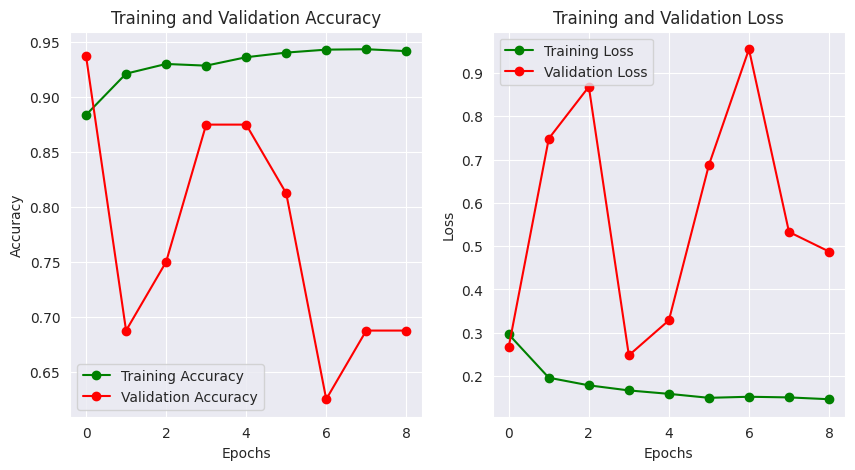

In [ ]:
epochs = range(len(trained.history['accuracy']))
fig, ax = plt.subplots(1, 2)
train_accuracy = trained.history['accuracy']
train_loss = trained.history['loss']
val_accuracy = trained.history['val_accuracy']
val_loss = trained.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs, train_accuracy, '-og', label = 'Training Accuracy')
ax[0].plot(epochs, val_accuracy, '-or', label = 'Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, '-og', label = 'Training Loss')
ax[1].plot(epochs, val_loss, '-or', label = 'Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

20/20 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step


In [ ]:
print(classification_report(y_test, predictions, target_names = labels))

              precision    recall  f1-score   support

      normal       0.88      0.87      0.87       234
   pneumonia       0.92      0.93      0.92       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



<Axes: >

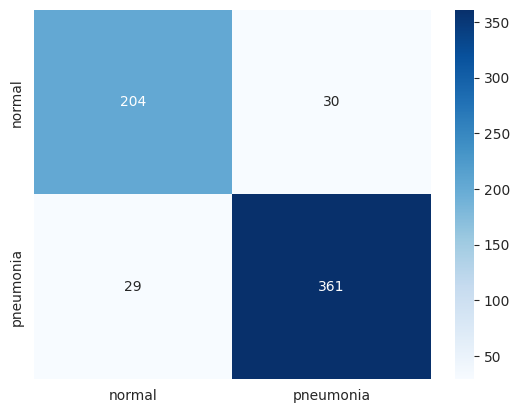

In [ ]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels = labels, yticklabels = labels)